# Final Event for NexGenMap

This material is part of Final Event of NexGenMap Project.

The NexGenMap is a project that aims establish the next generation of land use and land cover mapping and monitoring tools, using high-res images (i.e. Planet data), cloud-computing platforms (i.e. Google Earth Engine and Google Cloud Computing) and machine learning and deep-learning techniques (e.g. Random Forest, U-Net and LSTM).

The main goal of this tutorial is present the codes, trained models and mapping products of the project. It's organized in:
* Data and Libraries
* Cattle Water Ponds Identification
* Center Pivots Identification

## Data and Libraries

All routines that will be used are in the module [nexutil](nexutil.py) and in the github organization [NexGenMap](https://github.com/NexGenMap). They have follow dependencies:
* [Gdal](https://pypi.org/project/GDAL/): manipulating geospatial raster data;
* [Numpy](http://www.numpy.org/): image computing;
* [Tensorflow](https://www.tensorflow.org/): deep-learning implementation;
* [Scikit-learn](http://scikit-learn.org): machine-learning support;
* [Scikit-image](http://scikit-image.org/): image histogram equalization;
* [Matplotlib](https://matplotlib.org/): image and chart visualization;
* [Seaborn](https://seaborn.pydata.org/): confusion matrix visualization;
* [Psutil](https://psutil.readthedocs.io/en/latest/): python system and process utilities
* [tqdm](https://github.com/tqdm/tqdm): python progress bar

Please install them using an specific OS commands or PIP [from setup.sh](https://github.com/NexGenMap/dl-semantic-segmentation/blob/master/scripts/setup.sh):

In [ ]:
%%bash
echo "Setup OS packages"

apt-get -y update
apt install -y git wget python3 python3-dev python3-gdal gdal-bin libgdal-dev
apt upgrade -y git wget python3 python3-dev python3-gdal gdal-bin libgdal-dev

echo "Setup Python dependencies packages"

pip3 install numpy
pip3 install tensorflow-gpu==1.11.0 
pip3 install scikit-image
pip3 install scikit-learn 
pip3 install matplotlib 
pip3 install seaborn
pip3 install psutil
pip3 install tqdm

echo "Installation Done"

Import the [nexutil](nexutil.py) module

In [1]:
import nexutil

...and now download the repositories [dl-semantic-segmentation](https://github.com/NexGenMap/dl-semantic-segmentation), [dl-agriculture](https://github.com/NexGenMap/dl-agriculture), [dl-time-series](https://github.com/NexGenMap/dl-time-series).

In [ ]:
nexutil.download_extract_zipfile('https://github.com/NexGenMap/dl-semantic-segmentation/archive/master.zip', 'dl-semantic-segmentation.zip')
nexutil.download_extract_zipfile('https://github.com/NexGenMap/dl-agriculture/archive/master.zip', 'dl-agriculture.zip')
nexutil.download_extract_zipfile('https://github.com/NexGenMap/dl-time-series/archive/master.zip', 'dl-time-series.zip')

## Cattle Water Ponds
In this section, you will predict/classify the cattle water ponds of a Planet image, using a pre-trained model based in the neural network U-Net. 

Fisrt, import the repository [dl-semantic-segmentation](https://github.com/NexGenMap/dl-semantic-segmentation):

In [2]:
nexutil.import_repository('dl-semantic-segmentation-master/src')

... and now download the data and the pre-trained model:

In [2]:
nexutil.download_extract_zipfile(
    file_url='https://www.lapig.iesa.ufg.br/lapig/nextgenmap-data/tutorial-sessions/cattle_water_ponds.zip',
    filename='cattle_water_ponds.zip',
    destination='data'
)

Extracting to data


### Image Visualization

The model uses two images, one from dry season and another from wet season, to detect the cattle water ponds, seeking water levels variation between these images. 

Let's visualize these two images:

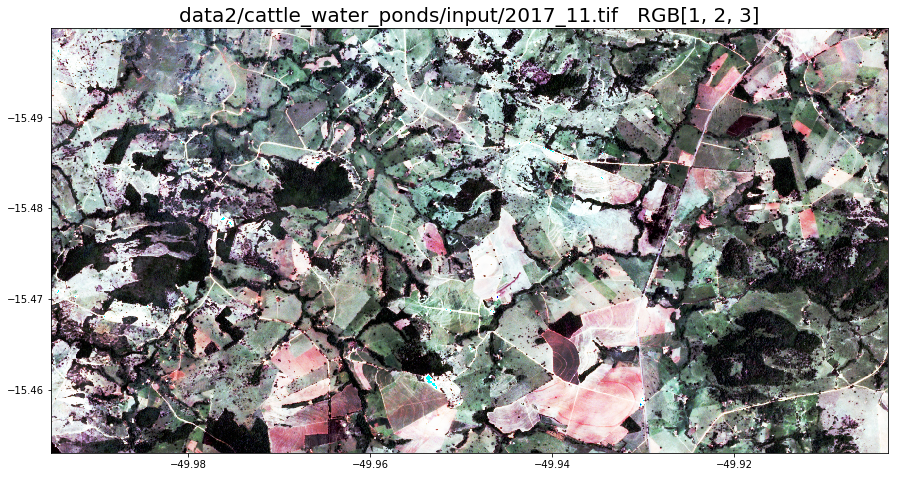

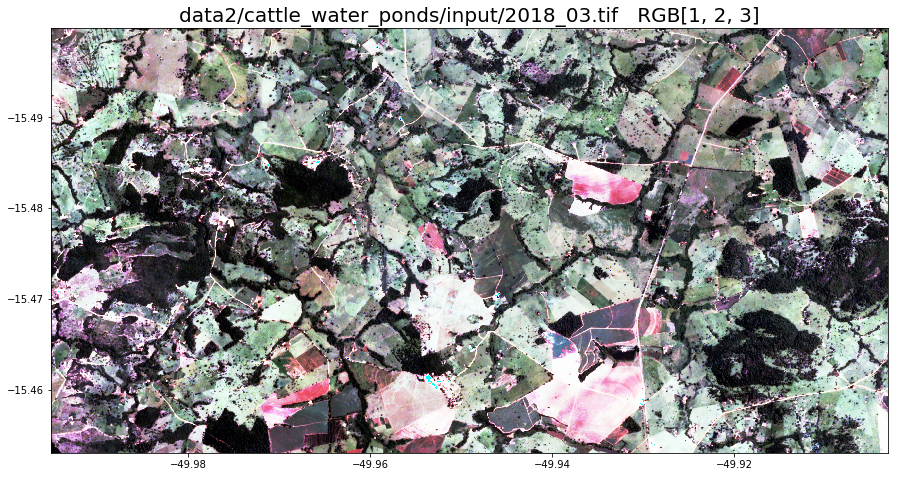

In [2]:
image_dry = 'data2/cattle_water_ponds/input/2017_11.tif'
image_wet = 'data2/cattle_water_ponds/input/2018_03.tif'
scale_factor = 0.0001

nexutil.vis_image(image_dry, bands=[1,2,3], scale_factor=scale_factor)
nexutil.vis_image(image_wet, bands=[1,2,3], scale_factor=scale_factor)

Besides the RGB bands, these images have NIRs bands. 

Let's visualize the NIR band in the green channel:

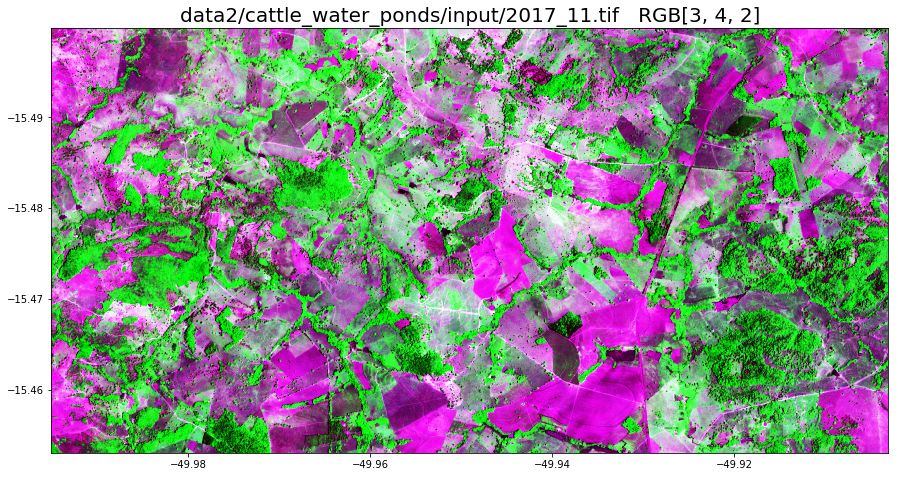

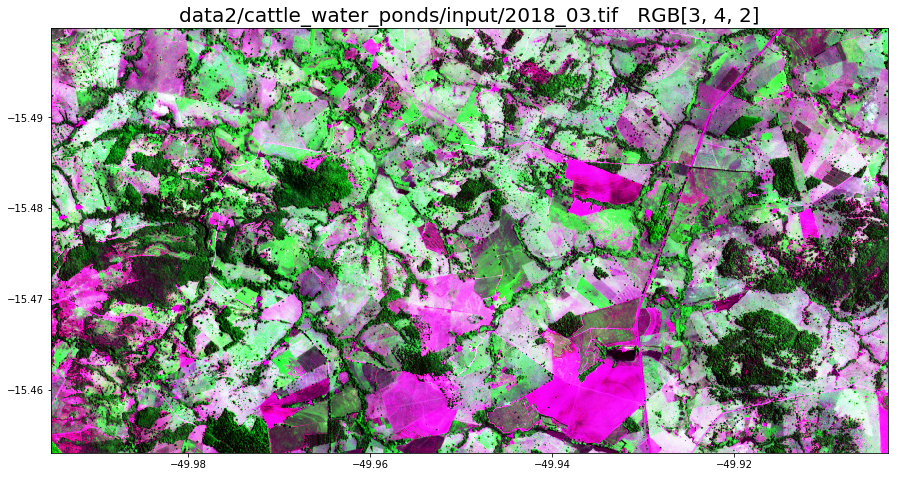

In [11]:
nexutil.vis_image(image_dry, bands=[3,4,2], scale_factor=scale_factor)
nexutil.vis_image(image_wet, bands=[3,4,2], scale_factor=scale_factor)

*How many cattle water ponds there is the region ???*

Check in the reference/test data of cattle water pounds:

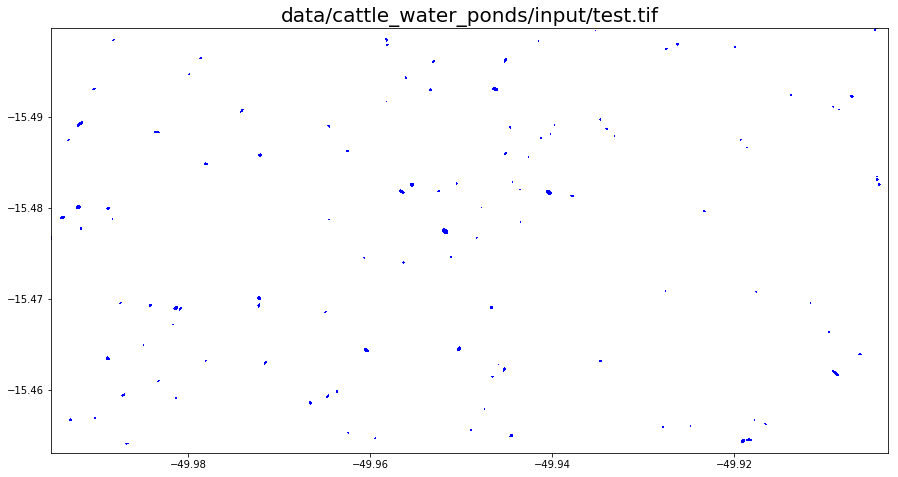

In [3]:
cattle_water_ponds_test = 'data/cattle_water_ponds/input/test.tif'

nexutil.vis_refimage(cattle_water_ponds_test, color_array=['white','blue'])

A zoom-in should help in the indentification:

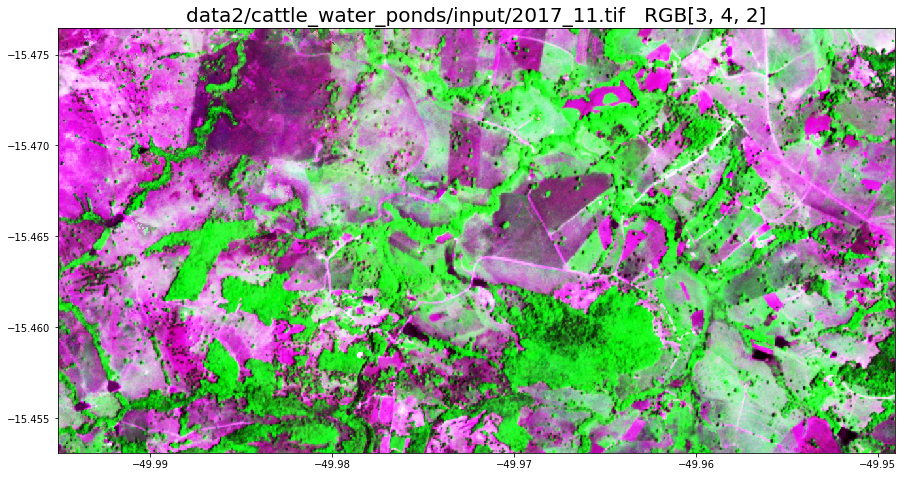

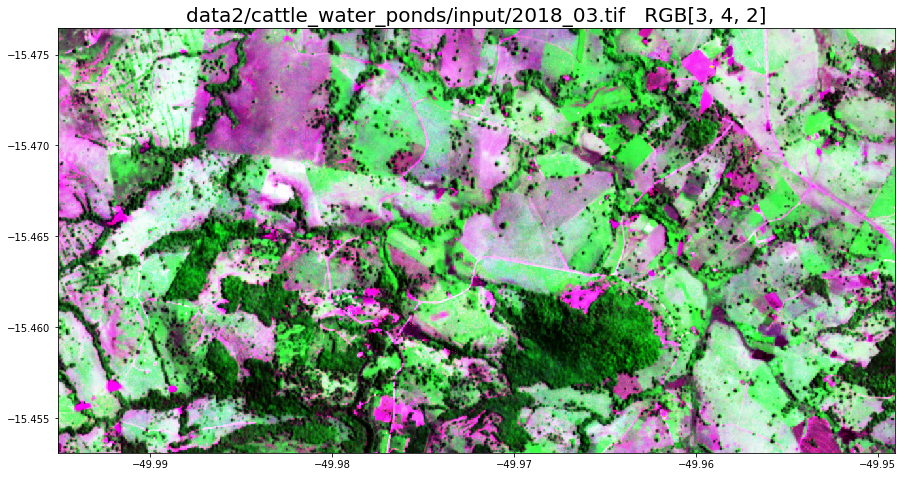

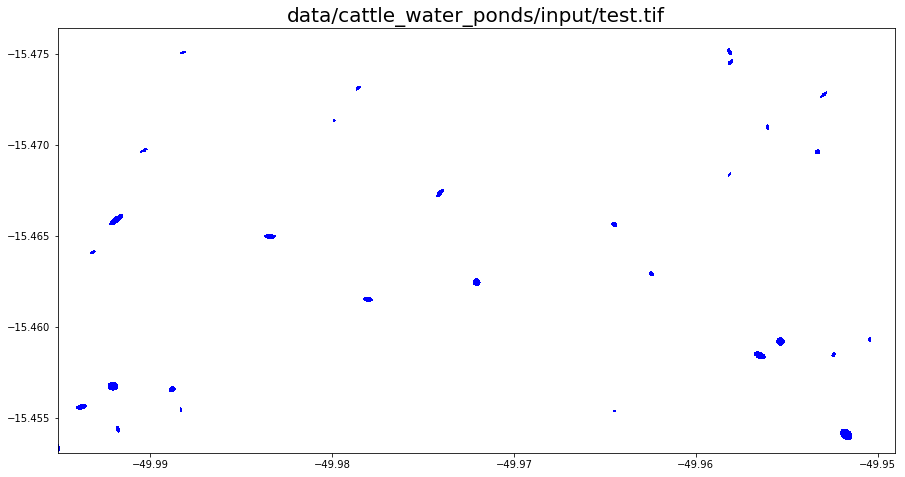

In [4]:
nexutil.vis_image(image_dry, bands=[3,4,2], scale_factor=scale_factor, zoom=2)
nexutil.vis_image(image_wet, bands=[3,4,2], scale_factor=scale_factor, zoom=2)
nexutil.vis_refimage(cattle_water_ponds_test, color_array=['white','blue'], zoom=2)

### Chip Classification
In the section you will generate chips for the throughout of region, considering the wet and the dry season imagens, and the reference map image. The generated chips will be predicted using the pre-trained model and a accuracy assessment will be conducted considering the reference map.

First, you need stack all the images to produce a [Virtual Raster Dataset](https://www.gdal.org/gdal_vrttut.html). Use VRT is a simple way to generate stacked files, because it will produce a xml file that reference all the input images.

In [7]:
import stack_imgs

stacked_vrt = 'data/cattle_water_ponds/input/stacked.vrt'


stack_imgs.create_vrt_output(
    input_imgs=[image_dry, image_wet], 
    output_vrt=stacked_vrt, 
    ref_img=cattle_water_ponds_test, 
    bands=[1,2,3,4]
)

Creating vrt file data/cattle_water_ponds/input/stacked.vrt


Now, use the producerd VRT file to generate the chips. To get more info about these parameters, check the [usages of repository](https://github.com/NexGenMap/dl-semantic-segmentation#usages).

In [8]:
import generate_chips

chips_dir = 'data/cattle_water_ponds/chips' 

input_chips, expected_chips = generate_chips.exec(
    img_path=stacked_vrt, 
    output_dir=chips_dir, 
    chip_size=100, 
    pad_size=93, 
    flip=False, 
    rotate=False, 
    shuffle=False
)

Analyzing data/cattle_water_ponds/input/stacked.vrt image.
Generating 86 chips into data/cattle_water_ponds/chips directory.


The routine produced 86 chips, let's check them:

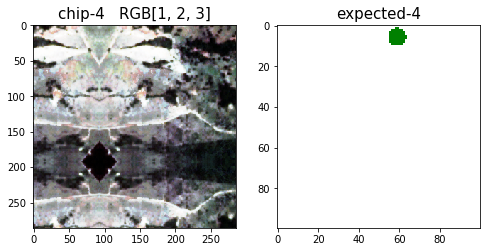

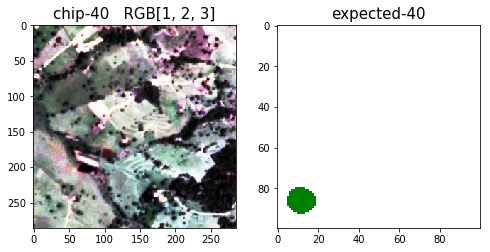

In [15]:
nexutil.vis_chip_from_numpy(input_chips, expected_chips, idx=4)
nexutil.vis_chip_from_numpy(input_chips, expected_chips, idx=40)

Some observations:
* The input and expected chips have different size, respectivamente 286x286 and 100x100. Check the [U-Net paper](https://arxiv.org/pdf/1505.04597.pdf) to understand why.
* The chip 4 is located in the left boundary of image, and its left pad was filled using [reflect strategy of numpy.pad](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html).

Let's instantiate the model, a implementation using [Estimator API of Tensorflow](https://www.tensorflow.org/api_docs/python/tf/estimator/Estimator), with [batch normalization](https://arxiv.org/abs/1502.03167), [IoU loss function](https://link.springer.com/chapter/10.1007/978-3-319-50835-1_22) and [Nadam Optimizer](https://openreview.net/pdf?id=OM0jvwB8jIp57ZJjtNEZ). To get more info about the its architecture check [this conference paper](https://www.lapig.iesa.ufg.br/drive/index.php/s/mIP4PNoauX4IE4U).

In [13]:
import tensorflow as tf

import image_utils
from models import unet as md

model_dir = 'data/cattle_water_ponds/model'

param_path = image_utils.new_filepath('train_params.dat', directory=model_dir)
params = image_utils.load_object(param_path)

estimator = tf.estimator.Estimator(
    model_fn=md.description, 
    params=params, 
    model_dir=model_dir
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f497368a748>, '_model_dir': 'data/cattle_water_ponds/model', '_evaluation_master': '', '_tf_random_seed': None, '_service': None, '_master': '', '_device_fn': None, '_save_summary_steps': 100, '_eval_distribute': None, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_log_step_count_steps': 100, '_keep_checkpoint_max': 5, '_task_id': 0, '_keep_checkpoint_every_n_hours': 10000, '_protocol': None, '_experimental_distribute': None, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_global_id_in_cluster': 0, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True}


Now, use the model to predict all the chips:

In [14]:
import numpy as np

input_fn = tf.estimator.inputs.numpy_input_fn(
    x = { "data": input_chips[:,:,:,0:8] }, 
    shuffle=False
)
model_predict = estimator.predict(input_fn=input_fn)

predicted_chips = []
for predicted_chip in model_predict:
    predicted_chip = image_utils.discretize_values(predicted_chip, 1, 0)
    predicted_chips.append(predicted_chip)

predicted_chips = np.stack(predicted_chips)

print('Shape of predicted_chips: ' + str(predicted_chips.shape))
print('Shape of expected_chips: ' + str(expected_chips.shape))

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from data/cattle_water_ponds/model/model.ckpt-336100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Shape of predicted_chips: (86, 100, 100, 1)
Shape of expected_chips: (86, 100, 100, 1)


Let's check the expected and predicted result:

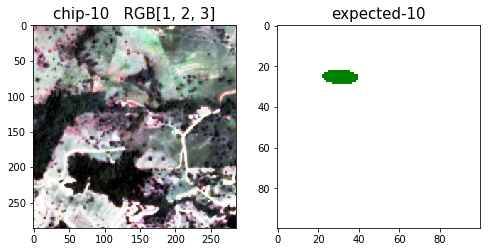

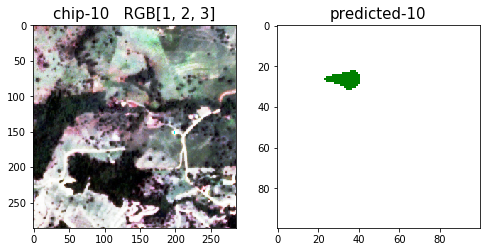

In [17]:
nexutil.vis_chip_from_numpy(input_chips, expected_chips, idx=10)
nexutil.vis_chip_from_numpy(input_chips, predicted_chips, idx=10, title_prefix='predicted')

Using the expected and predicted chips, let's calculate the [precision](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html), [recall](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) and [f1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) (for more information about [classification metrics](http://scikit-learn.org/stable/modules/model_evaluation.html)):

In [18]:
import evaluate_model

evaluate_model.exec(
    model_dir=model_dir, 
    chips_dir=chips_dir, 
    eval_size=1.0
)

Evaluating the model stored into data/cattle_water_ponds/model
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f496fbde4e0>, '_model_dir': 'data/cattle_water_ponds/model', '_evaluation_master': '', '_tf_random_seed': None, '_service': None, '_master': '', '_device_fn': None, '_save_summary_steps': 100, '_eval_distribute': None, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_log_step_count_steps': 100, '_keep_checkpoint_max': 5, '_task_id': 0, '_keep_checkpoint_every_n_hours': 10000, '_protocol': None, '_experimental_distribute': None, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_global_id_in_cluster': 0, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling mo

### Image Classification
In the section you will classify all the region, at once, producing a raster output file with predicted result.

Let's do it (To get more info about these parameters, check the [usages of repository](https://github.com/NexGenMap/dl-semantic-segmentation#usages)):

In [19]:
import classify_imgs

output_dir = 'data/cattle_water_ponds/output'

classify_imgs.exec(
    images=[stacked_vrt], 
    model_dir=model_dir, 
    output_dir=output_dir
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f49705d8518>, '_model_dir': 'data/cattle_water_ponds/model', '_evaluation_master': '', '_tf_random_seed': None, '_service': None, '_master': '', '_device_fn': None, '_save_summary_steps': 100, '_eval_distribute': None, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_log_step_count_steps': 100, '_keep_checkpoint_max': 5, '_task_id': 0, '_keep_checkpoint_every_n_hours': 10000, '_protocol': None, '_experimental_distribute': None, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_global_id_in_cluster': 0, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True}
Reading image data/cattle_water_ponds/input/stacked.vrt: memory percentage 8.3%
Reading image data/cattle_water_ponds/input/stac

Reading image data/cattle_water_ponds/input/stacked.vrt: memory percentage 8.5%
Reading image data/cattle_water_ponds/input/stacked.vrt: memory percentage 8.5%
Reading image data/cattle_water_ponds/input/stacked.vrt: memory percentage 8.5%
Reading image data/cattle_water_ponds/input/stacked.vrt: memory percentage 8.5%
Reading image data/cattle_water_ponds/input/stacked.vrt: memory percentage 8.5%
Reading image data/cattle_water_ponds/input/stacked.vrt: memory percentage 8.5%
Reading image data/cattle_water_ponds/input/stacked.vrt: memory percentage 8.6%
Reading image data/cattle_water_ponds/input/stacked.vrt: memory percentage 8.6%
Reading image data/cattle_water_ponds/input/stacked.vrt: memory percentage 8.6%
Reading image data/cattle_water_ponds/input/stacked.vrt: memory percentage 8.6%
Reading image data/cattle_water_ponds/input/stacked.vrt: memory percentage 8.6%
Reading image data/cattle_water_ponds/input/stacked.vrt: memory percentage 8.6%
Reading image data/cattle_water_ponds/in

Reading image data/cattle_water_ponds/input/stacked.vrt: memory percentage 8.9%
Reading image data/cattle_water_ponds/input/stacked.vrt: memory percentage 8.9%
Reading image data/cattle_water_ponds/input/stacked.vrt: memory percentage 8.9%
Reading image data/cattle_water_ponds/input/stacked.vrt: memory percentage 8.9%
Reading image data/cattle_water_ponds/input/stacked.vrt: memory percentage 8.9%
Reading image data/cattle_water_ponds/input/stacked.vrt: memory percentage 8.9%
Reading image data/cattle_water_ponds/input/stacked.vrt: memory percentage 8.9%
Reading image data/cattle_water_ponds/input/stacked.vrt: memory percentage 8.9%
Reading image data/cattle_water_ponds/input/stacked.vrt: memory percentage 8.9%
Reading image data/cattle_water_ponds/input/stacked.vrt: memory percentage 8.9%
Reading image data/cattle_water_ponds/input/stacked.vrt: memory percentage 8.9%
Reading image data/cattle_water_ponds/input/stacked.vrt: memory percentage 8.9%
Reading image data/cattle_water_ponds/in

Let's check the expected and predicted result:

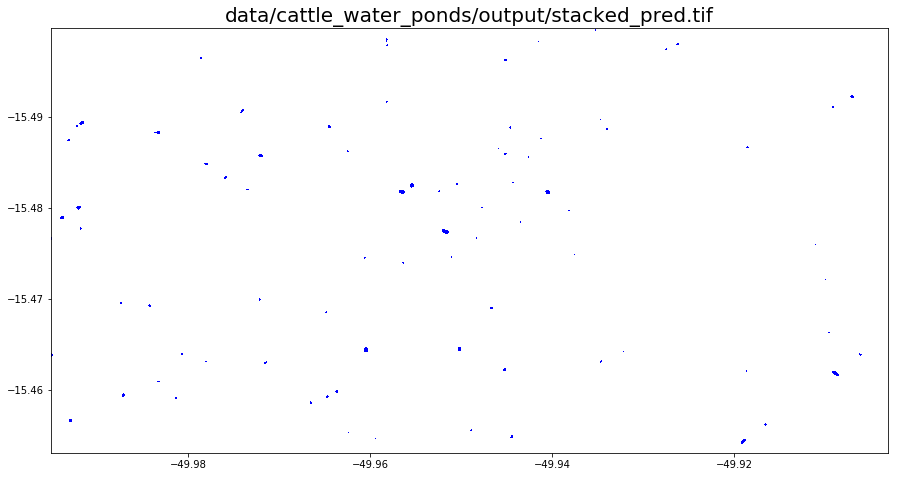

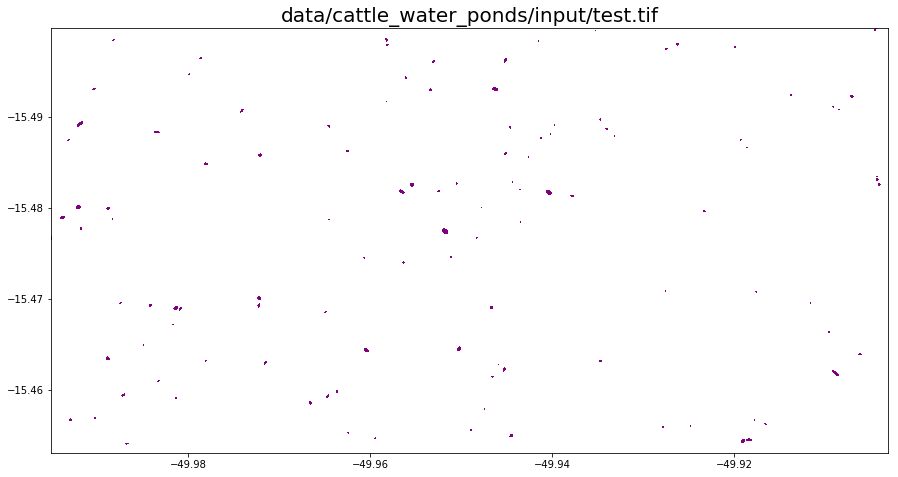

In [22]:
nexutil.vis_refimage('data/cattle_water_ponds/output/stacked_pred.tif', color_array=['white','blue'])
nexutil.vis_refimage('data/cattle_water_ponds/input/test.tif', color_array=['white','purple'])

A zoom-in should help:

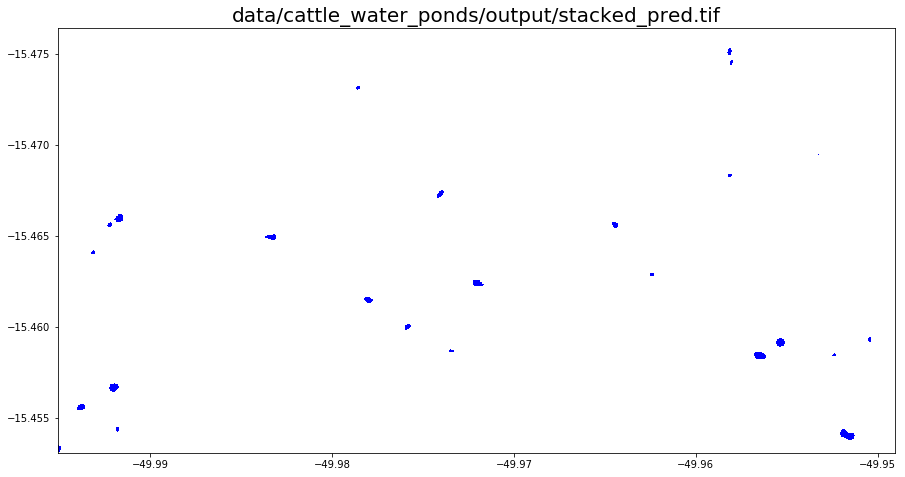

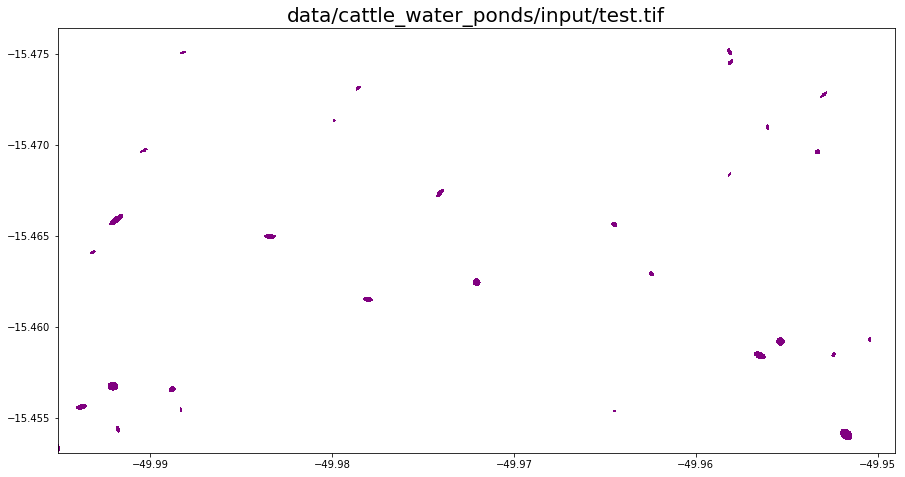

In [23]:
nexutil.vis_refimage('data/cattle_water_ponds/output/stacked_pred.tif', color_array=['white','blue'], zoom=2)
nexutil.vis_refimage('data/cattle_water_ponds/input/test.tif', color_array=['white','purple'], zoom=2)

## Center Pivots
In this section, you will predict/classify the center pivots of a Planet image, using a pre-trained model based in the neural network U-Net. 

Fisrt, import the repository [dl-agriculture](https://github.com/NexGenMap/dl-agriculture):

In [3]:
# If you imported the dl-semantic-segmentation repository, you should put True here
replace_last = True 

nexutil.import_repository('dl-agriculture-master/', replace_last=replace_last) 

...and its main module:

In [4]:
import run

Let's visualize the image input:

In [ ]:
input_image = 'data/center_pivot/input.tif'
nexutil.vis_image(input_image, bands=[1,2,3])

*How many center pivot there is the image ???*

Let's run the model to identify center pivots:

In [6]:
params = { 
    'tensorboard_images_max_outputs': 2,
    'learning_rate': 0.00005,
    'num_classes': 2
}

run.predict(
    input_path = 'data/center_pivot/input.tif',
    output_path = 'data/center_pivot/output.tif',
    chip_size = 1024,
    channels = 4,
    grids = 2,
    model = 'unet',
    model_dir = 'data/center_pivot/model',
    batch_size = 5,
    params = params
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_protocol': None, '_log_step_count_steps': 100, '_device_fn': None, '_num_ps_replicas': 0, '_train_distribute': None, '_save_checkpoints_secs': 600, '_model_dir': 'data/center_pivot/model', '_save_checkpoints_steps': None, '_task_id': 0, '_num_worker_replicas': 1, '_task_type': 'worker', '_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe74b6e3630>, '_tf_random_seed': None, '_eval_distribute': None, '_global_id_in_cluster': 0, '_save_summary_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_evaluation_master': '', '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_is_chief': True, '_service': None, '_keep_checkpoint_max': 5, '_experimental_distribute': None}
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipel

Now, check the model result:

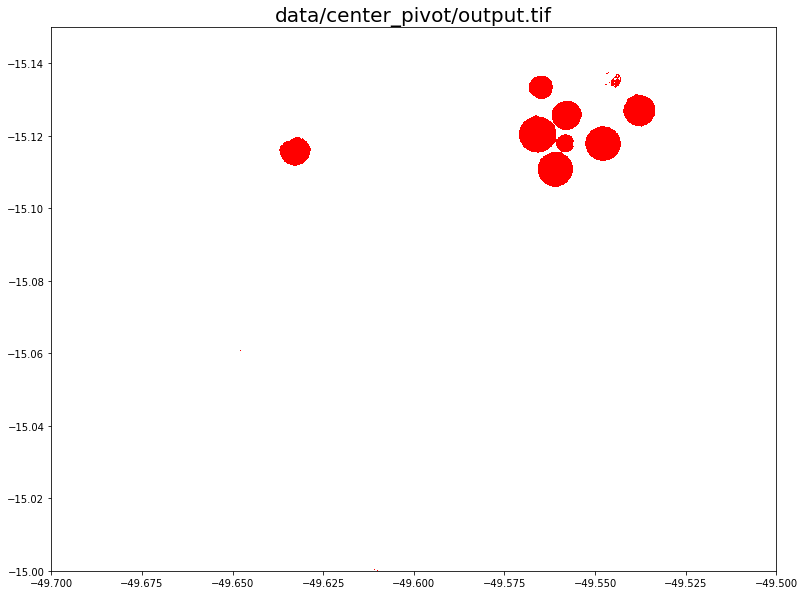

In [7]:
nexutil.vis_refimage('data/center_pivot/output.tif',color_array=['white','red'])